,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Размер датасета: (1338, 7)

Пропуски:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


Количество выбросов:
age           0
bmi           9
children      0
charges     139
dtype: int64

Колонки после кодирования:
['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest']


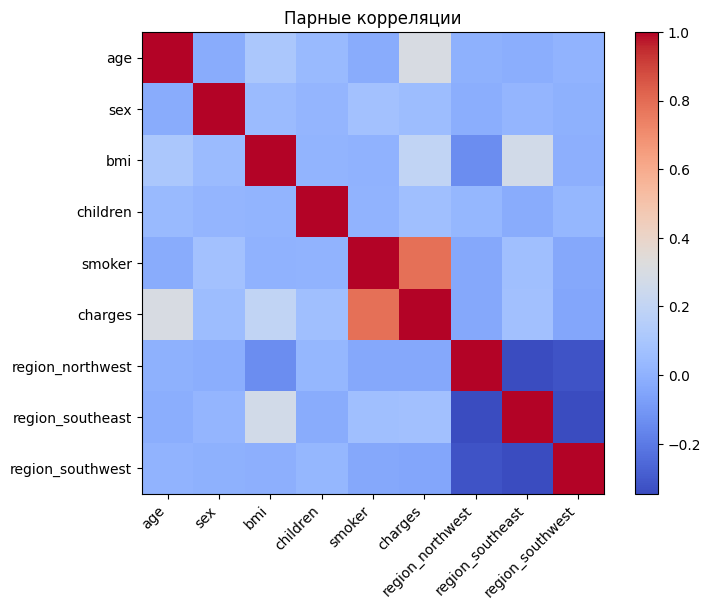

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ==============================================
# 1. Подготовка данных
# ==============================================

path = '/Users/qooriq/PycharmProjects/oiad-1-2025/datasets/insurance.csv'

df = pd.read_csv(path)
display(df.head())

print("Размер датасета:", df.shape)
print("\nПропуски:")
print(df.isnull().sum())

df.info()

display(df.describe(include='all'))

# Поиск выбросов (IQR)
def detect_outliers_iqr(df, numeric_cols):
    outliers = pd.DataFrame(False, index=df.index, columns=numeric_cols)
    for col in numeric_cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outliers[col] = (df[col] < lower) | (df[col] > upper)
    return outliers

numeric_cols = ['age', 'bmi', 'children', 'charges']
outliers = detect_outliers_iqr(df, numeric_cols)
print("Количество выбросов:")
print(outliers.sum())

# Кодирование категориальных признаков
df_enc = df.copy()
df_enc['sex'] = df_enc['sex'].map({'female': 0, 'male': 1})
df_enc['smoker'] = df_enc['smoker'].map({'no': 0, 'yes': 1})
df_enc = pd.get_dummies(df_enc, columns=['region'], drop_first=True)

print("\nКолонки после кодирования:")
print(df_enc.columns.tolist())

# Визуализация корреляций
corr = df_enc.corr()
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(corr, cmap='coolwarm', interpolation='nearest')
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)
plt.title('Парные корреляции')
plt.colorbar(im)
plt.show()


In [4]:
# ==============================================
# 2. Многомерная линейная регрессия
# ==============================================

def add_intercept(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

def analytic_solution(X, y, reg_lambda=0.0):
    n_features = X.shape[1]
    A = X.T @ X
    if reg_lambda != 0:
        L = reg_lambda * np.eye(n_features)
        L[0,0] = 0
        A = A + L
    w = np.linalg.pinv(A) @ X.T @ y
    return w

def mse_loss(X, y, w, reg_lambda=0.0):
    preds = X @ w
    mse = np.mean((y - preds)**2)
    if reg_lambda != 0:
        w_reg = w.copy(); w_reg[0] = 0
        mse += reg_lambda * np.sum(w_reg**2)/X.shape[0]
    return mse

def gradient_descent(X, y, lr=1e-3, n_iters=10000, tol=1e-8, reg_lambda=0.0):
    n, d = X.shape
    w = np.zeros(d)
    history = []
    for i in range(n_iters):
        preds = X @ w
        err = preds - y
        grad = (2/n) * X.T @ err
        if reg_lambda != 0:
            w_reg = w.copy(); w_reg[0] = 0
            grad += (2*reg_lambda/n) * w_reg
        w -= lr * grad
        loss = mse_loss(X, y, w, reg_lambda)
        history.append(loss)
        if i>1 and abs(history[-2]-history[-1]) < tol:
            break
    return w, history

In [5]:
# ==============================================
# 3. Подготовка X, y и разделение данных
# ==============================================

y = df_enc['charges'].values
X = df_enc.drop(columns=['charges']).astype(float).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Xtr = add_intercept(X_train)
Xte = add_intercept(X_test)

Baseline MSE: 155391443.68461317
Analytic MSE: 33596915.85136154
GD MSE: 65320874.26243532


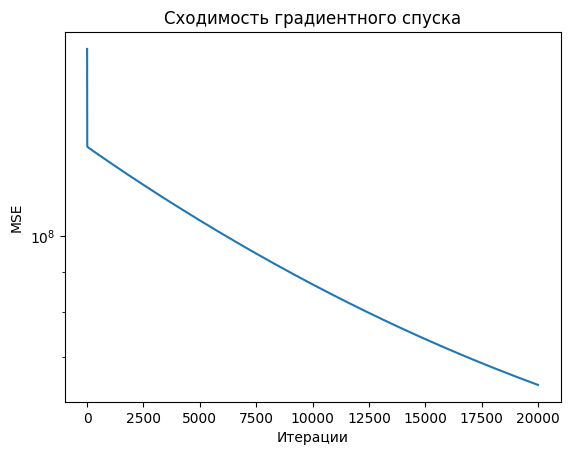

In [6]:
baseline_pred = np.mean(y_train)
baseline_mse = mean_squared_error(y_test, [baseline_pred]*len(y_test))

w_analytic = analytic_solution(Xtr, y_train)
preds_analytic = Xte @ w_analytic
mse_analytic = mean_squared_error(y_test, preds_analytic)

w_gd, hist = gradient_descent(Xtr, y_train, lr=1e-4, n_iters=20000)
preds_gd = Xte @ w_gd
mse_gd = mean_squared_error(y_test, preds_gd)

print("Baseline MSE:", baseline_mse)
print("Analytic MSE:", mse_analytic)
print("GD MSE:", mse_gd)

plt.plot(hist)
plt.title('Сходимость градиентного спуска')
plt.xlabel('Итерации')
plt.ylabel('MSE')
plt.yscale('log')
plt.show()

Лучший lambda analytical: 1e-05
Лучший lambda gd: 1e-05


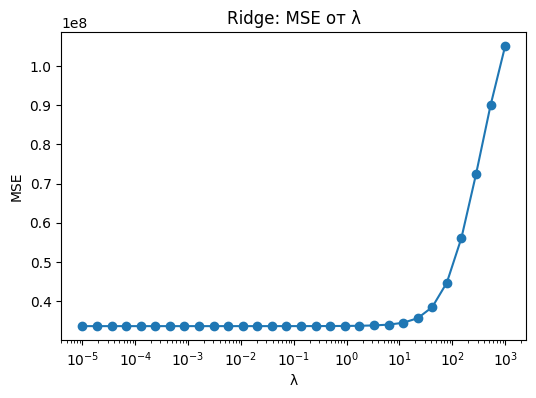

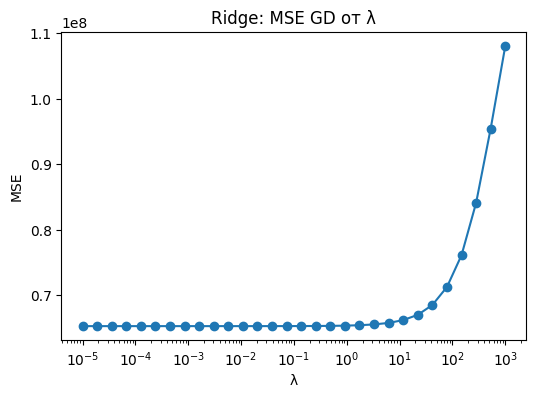

MSE Ridge analytical: 33596916.30608509
MSE Ridge gr: 65320875.05082109


In [7]:
# ==============================================
# 5. L2-регуляризация
# ==============================================

lambdas = np.logspace(-5, 3, 30)
results_analytical = []
results_gd = []
for lam in lambdas:
    w_ridge = analytic_solution(Xtr, y_train, reg_lambda=lam)
    w_ridge_gd, _ = gradient_descent(Xtr, y_train, lr=1e-4, n_iters=20000, reg_lambda=lam)
    preds_gd = Xte @ w_ridge_gd
    preds = Xte @ w_ridge
    mse_val = mean_squared_error(y_test, preds)
    mse_val_gd = mean_squared_error(y_test, preds_gd)
    results_analytical.append((lam, mse_val))
    results_gd.append((lam, mse_val_gd))

df_ridge_analytical = pd.DataFrame(results_analytical, columns=['lambda', 'mse'])
df_ridge_gd = pd.DataFrame(results_gd, columns=['lambda', 'mse'])

best_lambda = df_ridge_analytical.loc[df_ridge_analytical['mse'].idxmin(), 'lambda']
best_lambda_gd = df_ridge_gd.loc[df_ridge_gd['mse'].idxmin(), 'lambda']
print("Лучший lambda analytical:", best_lambda)
print("Лучший lambda gd:", best_lambda_gd)

plt.figure(figsize=(6,4))
plt.semilogx(df_ridge_analytical['lambda'], df_ridge_analytical['mse'], marker='o')
plt.title('Ridge: MSE от λ')
plt.xlabel('λ')
plt.ylabel('MSE')
plt.show()

plt.figure(figsize=(6,4))
plt.semilogx(df_ridge_gd['lambda'], df_ridge_gd['mse'], marker='o')
plt.title('Ridge: MSE GD от λ')
plt.xlabel('λ')
plt.ylabel('MSE')
plt.show()

# Финальное обучение с лучшим λ
w_ridge_gd, _ = gradient_descent(Xtr, y_train, lr=1e-4, n_iters=20000, reg_lambda=best_lambda_gd)
w_ridge_final = analytic_solution(Xtr, y_train, reg_lambda=best_lambda)
preds_ridge_gd = Xte @ w_ridge_gd
preds_ridge = Xte @ w_ridge_final
mse_ridge_anal = mean_squared_error(y_test, preds_ridge)
mse_ridge_gd = mean_squared_error(y_test, preds_ridge_gd)
print("MSE Ridge analytical:", mse_ridge_anal)
print("MSE Ridge gr:", mse_ridge_gd)

,Модель,MSE
0,Baseline,1.553914e+08
1,Linear (Analytic),3.359692e+07
2,Linear (GD),6.532087e+07
3,Ridge analytical (λ=1.00e-05),3.359692e+07
4,Ridge gd (λ=1.00e-05),6.532088e+07


ASFASFGAFASFA:  [155391443.68461317, 33596915.85136154, 65320874.26243532, 33596916.30608509, 65320875.05082109]


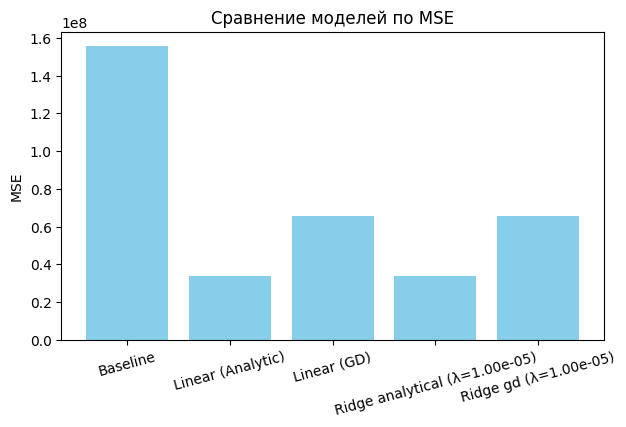


Ridge-регуляризация обычно уменьшает MSE и повышает устойчивость модели.


In [8]:
# ==============================================
# Сравнение моделей
# ==============================================
comparison = pd.DataFrame({
    'Модель': ['Baseline', 'Linear (Analytic)', 'Linear (GD)', f'Ridge analytical (λ={best_lambda:.2e})', f'Ridge gd (λ={best_lambda:.2e})'],
    'MSE': [baseline_mse, mse_analytic, mse_gd, mse_ridge_anal, mse_ridge_gd]
})
display(comparison)

print("ASFASFGAFASFA: ", [baseline_mse, mse_analytic, mse_gd, mse_ridge_anal, mse_ridge_gd])

plt.figure(figsize=(7,4))
plt.bar(comparison['Модель'], comparison['MSE'], color='skyblue')
plt.title('Сравнение моделей по MSE')
plt.ylabel('MSE')
plt.xticks(rotation=15)
plt.show()

# ==============================================
# Выводы
# ==============================================
print("\nRidge-регуляризация обычно уменьшает MSE и повышает устойчивость модели.")
